In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LinearRegression
from pathlib import Path  


# Settings
%load_ext autoreload
%autoreload 2

# American Put Options with Dynamic Programming

## Geometrical Brownian Motions, Black Scholes and LSM by Longstaff and Schwartz 
**Readings:** 
- 📖 Longstaff and Schwartz (2001). Valuing American Options by Simulation: A Simple Least-Squares Approach. Sections 1-3.


by Emil Bille, Carl Adrian Møller and Silke Kofoed Christiansen

University of Copenhagen

## Set up option pricing class

In [2]:
import numpy as np

class OptionPricingClass(object):
    """ Class for American put option pricing using Longstaff-Schwartz (2001):
    
    T : float : time to maturity (in year fractions)
    M : int : grid or granularity for time (in number of total points)
    r : float : constant risk-free short rate
    sigma :  float : volatility factor in diffusion term 
    
    """

    def __init__(self, S0, strike, T, M, r, sigma, simulations, deg, basis_func):
        self.S0 = float(S0)
        self.strike = float(strike)
        self.T = float(T)
        self.M = int(M)
        self.r = float(r)
        self.sigma = float(sigma)
        self.simulations = int(simulations)
        self.deg = deg
        self.basis_func = basis_func
        self.time_unit = self.T / float(self.M)
        self.discount = np.exp(-self.r * self.time_unit)


    @property
    def MCprice_matrix(self, seed = 123):
        """ Returns MC price matrix rows: time columns: price-path simulation """
        np.random.seed(seed)
        MCprice_matrix = np.zeros((self.M + 1, self.simulations), dtype=np.float64)
        MCprice_matrix[0,:] = self.S0
        for t in range(1, self.M + 1):
            brownian = np.random.standard_normal(int(self.simulations / 2))
            brownian = np.concatenate((brownian, -brownian))
            MCprice_matrix[t, :] = (MCprice_matrix[t - 1, :]
                                  * np.exp((self.r - self.sigma ** 2 / 2.) * self.time_unit
                                  + self.sigma * brownian * np.sqrt(self.time_unit)))
        return MCprice_matrix

    @property
    def MCpayoff(self):
        """Returns the inner-value of American Put Option"""
        payoff = np.maximum(self.strike - self.MCprice_matrix,
                            np.zeros((self.M + 1, self.simulations),
                            dtype=np.float64))
        return payoff

    @property
    def value_vector(self):
        value_matrix = np.zeros_like(self.MCpayoff)
        cashflow, paths, continuation_matrix = [[],[],[]]
        value_matrix[-1, :] = self.MCpayoff[-1, :]
        for t in range(self.M - 1, 0 , -1):
            X = self.MCprice_matrix[t, :]
            Y = value_matrix[t + 1, :] * self.discount
            
            if self.basis_func == 'manual': # Manual calculation of predictors
                #print(basis_func)
                # Set up predictors
                X = pd.DataFrame(X)
                X_2 = X**2 # Created squared variable
                X_3 = X**3 # Created squared variable
                X_4 = X**4 # Created squared variable
                X_5 = X**5 # Created squared variable
                predictors = pd.concat([X, X_2, X_3, X_4, X_5], axis=1) # combine X variables
                reg = LinearRegression().fit(predictors, Y) # fit regression
                continuation_value = reg.predict(predictors) # continuation values
                value_matrix[t, :] = np.where(self.MCpayoff[t, :] > continuation_value, self.MCpayoff[t, :],
                                          value_matrix[t + 1, :] * self.discount)
                continuation_matrix.append(continuation_value)
                paths.append(X)
                cashflow.append(self.MCpayoff[t, :])
                
            if self.basis_func == 'polyfit': 
                reg = np.polyfit(X, Y, deg = self.deg) # Fit Regression
                continuation_value = np.polyval(reg, X) # Continuation Values (Evaluate regression)
                value_matrix[t, :] = np.where(self.MCpayoff[t, :] > continuation_value, self.MCpayoff[t, :],
                                          value_matrix[t + 1, :] * self.discount)# value matrix
                continuation_matrix.append(continuation_value)
                paths.append(X)
                cashflow.append(self.MCpayoff[t, :])
                
            if self.basis_func == 'chebyshev': 
                reg = np.polynomial.chebyshev.chebfit(X, Y, deg= self.deg, rcond=None, full=False, w=None) # fit regression
                continuation_value = np.polynomial.chebyshev.chebval(X, reg) # continuation values
                value_matrix[t, :] = np.where(self.MCpayoff[t, :] > continuation_value, self.MCpayoff[t, :],
                                          value_matrix[t + 1, :] * self.discount) # value matrix
                continuation_matrix.append(continuation_value)
                paths.append(X)
                cashflow.append(self.MCpayoff[t, :])
                
            if self.basis_func == 'laguerre': 
                reg = np.polynomial.laguerre.lagfit(X, Y, deg= self.deg, rcond=None, full=False, w=None) # fit regression
                continuation_value = np.polynomial.laguerre.lagval(X, reg) # continuation values
                value_matrix[t, :] = np.where(self.MCpayoff[t, :] > continuation_value, self.MCpayoff[t, :],
                                          value_matrix[t + 1, :] * self.discount) # value matrix
                continuation_matrix.append(continuation_value)
                paths.append(X)
                cashflow.append(self.MCpayoff[t, :])
            
            
            if self.basis_func == 'hermite': 
                reg = np.polynomial.hermite.hermfit(X, Y, deg= self.deg, rcond=None, full=False, w=None) # fit regression
                continuation_value = np.polynomial.hermite.hermval(X, reg) # continuation values
                value_matrix[t, :] = np.where(self.MCpayoff[t, :] > continuation_value, self.MCpayoff[t, :],
                                          value_matrix[t + 1, :] * self.discount) # value matrix
                continuation_matrix.append(continuation_value)
                paths.append(X)
                cashflow.append(self.MCpayoff[t, :])
                
            if self.basis_func == 'legendre': 
                reg = np.polynomial.legendre.legfit(X, Y, deg= self.deg, rcond=None, full=False, w=None) # fit regression
                continuation_value = np.polynomial.legendre.legval(X, reg) # continuation values
                value_matrix[t, :] = np.where(self.MCpayoff[t, :] > continuation_value, self.MCpayoff[t, :],
                                          value_matrix[t + 1, :] * self.discount) # value matrix
                continuation_matrix.append(continuation_value)
                paths.append(X)
                cashflow.append(self.MCpayoff[t, :]* self.discount)
                
        return value_matrix[1,:] * self.discount, continuation_matrix, paths, cashflow,value_matrix

    @property
    def price(self): return np.sum(self.value_vector[1]) / float(self.simulations)
        

### Analysis of how the algortihm works

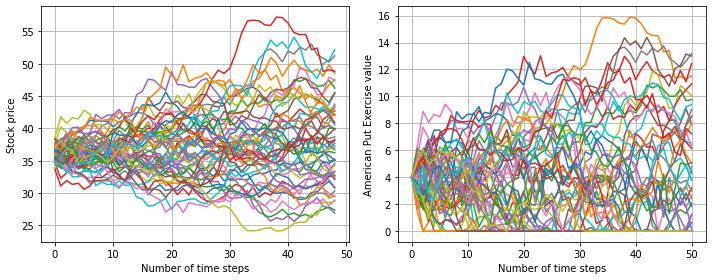

In [15]:
# initial parameters
S0, strike, T, M, r, sigma, deg, basis_func, simulations = 36, 40, 1, 50, 0.06, 0.2, 2, 'laguerre', 50

# Find the assosiated American put option
PUT = OptionPricingClass(S0, strike, T, M, r, sigma,simulations, deg, basis_func)
continuation_matrix = PUT.value_vector[1]
paths = PUT.value_vector[2]
cashflow = PUT.value_vector[3]
payoff = PUT.MCpayoff

# Plot the Stock price and exercise value
figsize = (10, 4)
plt.figure(figsize=figsize)
plt.subplot(1, 2, 1)
plt.plot(np.flip(paths))
plt.grid(True)
plt.xlabel('Number of time steps')
plt.ylabel('Stock price')

plt.subplot(1, 2, 2)
plt.plot(payoff)
plt.grid(True)
plt.xlabel('Number of time steps')
plt.ylabel('American Put Exercise value')
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Exercise / Continuation Value')

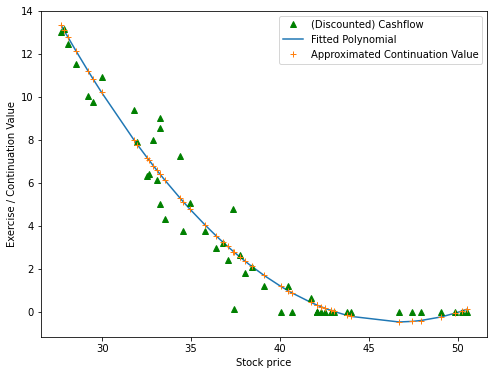

In [21]:
poly = pd.DataFrame(list(zip(paths[1], continuation_matrix[1])),
              columns=['X','poly']).set_index("X")

figsize = (8, 6)
plt.figure(figsize=figsize)
plt.plot(paths[1], payoff[-1], 'g^', zorder=2);
plt.plot(poly.sort_values(by = "X", ascending=True),"-",zorder=1);
plt.plot(paths[1], continuation_matrix[1],"+", zorder=3);
plt.legend(['(Discounted) Cashflow',
            'Fitted Polynomial',
            'Approximated Continuation Value'])
plt.xlabel('Stock price')
plt.ylabel('Exercise / Continuation Value')

In [17]:
intermediate_results = []

for i in (range(1, 50 - 1)):
    cashflow_i = payoff[-i] #
    x = paths[i]
    itm = payoff[-i] > 0
    poly_itm = pd.DataFrame(list(zip(paths[i][itm], continuation_matrix[i][itm])),
              columns=['X','poly']).set_index("X")
    poly = pd.DataFrame(list(zip(paths[i], continuation_matrix[i])),
              columns=['X','poly']).set_index("X")
    continuation = continuation_matrix[i]
    exercise = payoff[-i]
    ex_idx = itm & (exercise > continuation)
    intermediate_results.append((cashflow_i, x, poly_itm, poly, itm, continuation, exercise, ex_idx))

In [18]:
grey = '#dddd'

def plot_approx_n(n_steps, ax):
    cashflow_i, x, poly_itm, poly, itm, continuation, exercise, ex_idx = intermediate_results[n_steps]
    ax.plot(x, cashflow_i, '^', color='green', zorder=3); #
    ax.plot(x[ex_idx], exercise[ex_idx], 'x', color='red', zorder=5); 
    ax.plot(x[~ex_idx], exercise[~ex_idx], 'x', color=grey, zorder=4); 
    ax.plot(poly_itm.sort_values(by = "X", ascending=True),"-",zorder=2);
    ax.plot(poly.sort_values(by = "X", ascending=True),"grey",zorder=1);
    ax.legend(['(Discounted) Cashflow',
               'Favourable Exercise',
               'Unfavourable Exercise',
               'Approx. of Continuation Value',
               'Out-of-the-money Continuation Value'])

In [19]:
from ipywidgets import interact, IntSlider

@interact(n_steps=IntSlider(min=0, max=len(intermediate_results)-1, value=1))
def step(n_steps):
    fig, ax = plt.subplots()
    fig.set_figwidth(figsize[0])
    fig.set_figheight(figsize[1])
    plot_approx_n(n_steps, ax)
    plt.xlabel('Stock Price')
    plt.ylabel('Exercise / Continuation Value')

interactive(children=(IntSlider(value=1, description='n_steps', max=47), Output()), _dom_classes=('widget-inte…

Text(0, 0.5, 'Stock Price')

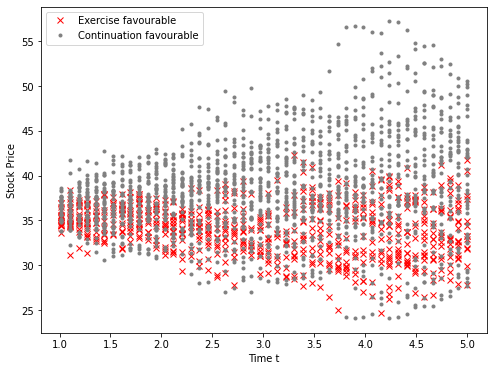

In [20]:
t = np.linspace(0, 5, 12*5)
exercise_times = []
exercises = []
non_exercise_times = []
non_exercises = []
for i, (cashflow, x, poly_itm, poly, itm, continuation, exercise, ex_idx) in enumerate(intermediate_results):
    for ex in x[ex_idx]:
        exercise_times.append(t[-i-1])
        exercises.append(ex)
    for ex in x[~ex_idx]:
        non_exercise_times.append(t[-i-1])
        non_exercises.append(ex)

plt.figure(figsize=figsize)
plt.plot(exercise_times, exercises, 'rx');
plt.plot(non_exercise_times, non_exercises, '.', color='grey');
plt.legend(['Exercise favourable', 'Continuation favourable'])
plt.xlabel('Time t')
plt.ylabel('Stock Price')
